# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standard columns, run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory created, they will be uploaded to IN-CORE Dataservice.

With the required files on IN-CORE Dataservice, the housing unit allocation method will run.
Functions are provided to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07cv9_run_HUA_workflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version: v6 - Run with option to not use IN-CORE
- 2023-01-27 - Generalize workflow using new Lumberton Building Data
- 2022-08-29 - v2 workflow
- 2022-10-06 - clean up code and test output for Salt Lake City
- 2023-09-29   Testing with new version of pyincore
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [1]:
# Do you want to use IN-CORE Dataservice? If yes, set to True
use_incore = True

In [2]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted
import scooby # Reports Python environment

# Check if using IN-CORE Dataservice
if use_incore:
    from pyincore import IncoreClient, Dataset, DataService

C:\Users\nathanael99\AppData\Local\Temp\ipykernel_57160\3545937410.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd # For reading in shapefiles


In [3]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_00e_geoutilities import spatial_join_points_to_poly
from pyncoda.ncoda_00h_bldg_archetype_structure import *
from pyncoda.ncoda_07a_generate_hui import generate_hui_functions
from pyncoda.ncoda_07c_generate_addpt import generate_addpt_functions
from pyncoda.ncoda_07d_run_hua_workflow import hua_workflow_functions
from pyncoda.CommunitySourceData.nsi_sec_usace_army_mil.nsi_01a_downloadfiles import download_nsi_files


In [5]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas','pyincore','pyincore_viz','ipyleaflet','seaborn','geopandas']))


--------------------------------------------------------------------------------
  Date: Fri Sep 29 17:05:42 2023 Eastern Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.8.16 | packaged by conda-forge | (default, Feb  1 2023, 15:53:35)
  [MSC v.1929 64 bit (AMD64)]

            pandas : 1.2.3
          pyincore : 1.8.0
      pyincore_viz : 1.8.1
        ipyleaflet : 0.17.2
           seaborn : 0.12.2
         geopandas : 0.12.2
             numpy : 1.24.2
             scipy : 1.10.0
           IPython : 8.10.0
        matplotlib : 3.6.3
            scooby : 0.7.1
--------------------------------------------------------------------------------


In [6]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\github\\intersect-community-data'

### Required Information: 


In [7]:
# For the variable that provides information on the residential building type, what are the possible values and the estimated number of housing units?
# For more examples see the file pyncoda\ncoda_00h_bldg_archetype_structure.py
basic_residential_archetypes = { 
        1 : {'Description' : 'Residential', 'HU estimate' : 1}
            }

Nofal_residential_archetypesv2 = { 
        1 : {'Description' : 
                'One-story sf residential building on a crawlspace foundation',
             'HU estimate' : 1},
        2 : {'Description' : 
                'One-story mf residential building on a slab-on-grade foundation',
              'HU estimate' : 1},
        3 : {'Description' : 
                'Two-story sf residential building on a crawlspace foundation',
            'HU estimate' : 1},
        4 : {'Description' : 
                'Two-story mf residential building on a slab-on-grade foundation',
            'HU estimate' : 1}
            }

In [8]:
# Edit Data Dictionary for Community

# Example of data dictionary for one community with one county
# Check how to capitalize the state name at
## https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/

# NOTE on file path length. WINDOWS has a limit of 260 characters for file path length.
# Community name needs to be short to avoid this limit.

communities = {'Galveston_TX' : {
                    'community_name' : 'Galveston, TX',
                    'focalplace_name' : 'Galveston',
                    'STATE' : 'TEXAS',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '48167', 'Name' : 'Galveston County, TX'}},
                    'building_inventory' : { 
                        'id' : '63ff6b135c35c0353d5ed3ac',
                        'note' : 'Building inventory for Galveston Island, TX',
                        'archetype_var' : 'arch_flood',
                        'residential_archetypes' : Nofal_residential_archetypesv2,
                        'building_area_var' : 'sq_foot',
                        'bldg_uniqueid' : 'guid',
                        'building_area_cutoff' : 300}
                                }
                }

version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [9]:
if use_incore:
    client = IncoreClient()
    # IN-CORE caches files on the local machine, it might be necessary to clear the memory
    client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.8.0


In [10]:
if use_incore:
    # create data_service object for loading files
    data_service = DataService(client)

## Read in Housing Unit Inventory or create a new one

In [11]:
generate_hui_df = generate_hui_functions(
                    communities =   communities,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder,
                    use_incore=     use_incore
                    )

hui_dataset_id = generate_hui_df.generate_hui_v2_for_incore()

# If using IN-CORE
if use_incore:
    # Housing Unit inventory
    housing_unit_inv_id = hui_dataset_id
    # load housing unit inventory as pandas dataframe
    housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
    filename = housing_unit_inv.get_file_path('csv')
    print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

    # Convert CSV to Pandas Dataframe
    housing_unit_inv_df = pd.read_csv(filename, header="infer")
else:
    housing_unit_inv_df = hui_dataset_id
    hui_dataset_id = 'local'

Generating Housing Unit Inventory v2.0.0 data for Galveston, TX
Connection successful to IN-CORE services. pyIncore version detected: 1.8.0
Number of datasets matching Housing Unit Inventory v2.0.0 data for Galveston, TX: 1
Dataset Housing Unit Inventory v2.0.0 data for Galveston, TX already exists in IN-CORE
Dataset already exists in IN-CORE with filename hui_v2-0-0_Galveston_TX_2010_rs1000.csv
Use dataset_id: 626322a7e74a5c2dfb3a72b0
Dataset already exists on IN-CORE, use dataset_id: 626322a7e74a5c2dfb3a72b0
The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\626322a7e74a5c2dfb3a72b0\hui_v2-0-0_Galveston_TX_2010_rs1000\hui_v2-0-0_Galveston_TX_2010_rs1000.csv


In [12]:
housing_unit_inv_df.head()

huid          blockid          bgid      tractid  \
0  B481677201001000H001  481677201001000  481677201001  48167720100   
1  B481677201001000H002  481677201001000  481677201001  48167720100   
2  B481677201001000H003  481677201001000  481677201001  48167720100   
3  B481677201001000H004  481677201001000  481677201001  48167720100   
4  B481677201001000H005  481677201001000  481677201001  48167720100   

   FIPScounty  numprec  ownershp  race  hispan  family  vacancy  gqtype  \
0       48167        1       1.0   1.0     0.0     0.0        0       0   
1       48167        1       1.0   1.0     0.0     0.0        0       0   
2       48167        1       1.0   1.0     0.0     0.0        0       0   
3       48167        1       1.0   1.0     0.0     0.0        0       0   
4       48167        1       1.0   1.0     0.0     0.0        0       0   

   incomegroup  hhinc  randincome  poverty  
0            6      3     31459.0      0.0  
1            6      3     34695.0      0.0  
2            7      3     38776.0      0.0  
3           10      3     52398.0      0.0  
4           11      3     69564.0      0.0

## Generate Address Point Inventory and Run Housing Unit Allocation

In [13]:
for community in communities.keys():
    # Set parameters for Address point generation
    bldg_inv_id = communities[community]['building_inventory']['id']
    archetype_var = communities[community]['building_inventory']['archetype_var']
    building_area_var = communities[community]['building_inventory']['building_area_var']
    building_area_cutoff = communities[community]['building_inventory']['building_area_cutoff']
    residential_archetypes = communities[community]['building_inventory']['residential_archetypes']
    
    # load building inventory
    # If using IN-CORE
    if use_incore:
        # Get the Unique ID
        bldg_uniqueid = 'guid'
        # Building inventory ID
        bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
        filename = bldg_inv.get_file_path('shp')
        print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)
        bldg_inv_gdf = gpd.read_file(filename)
    # Check if building inventory is comes  from a filename if filename key exists
    elif 'filename' in communities[community]['building_inventory'].keys():
        # Get the Unique ID
        bldg_uniqueid = communities[community]['building_inventory']['bldg_uniqueid']
        
        print("Building inventory is from a file")
        bldg_filename = communities[community]['building_inventory']['filename']
        bldg_inv_gdf = gpd.read_file(bldg_filename)
    # Check if building inventory is from NSI
    elif 'NSI' in bldg_inv_id:
        # Get the Unique ID
        bldg_uniqueid = communities[community]['building_inventory']['bldg_uniqueid']
        # make an empty dictionary for saving county NSI files
        county_nsi_gdf = {}
        for county in communities[community]['counties'].keys():
            county_fips = communities[community]['counties'][county]['FIPS Code']
            state_county_name  = communities[community]['counties'][county]['Name']
            print("Downloading NSI files for:")
            print(state_county_name,': county FIPS Code',county_fips)
            county_nsi_gdf[county_fips] = download_nsi_files(county_fips=county_fips)
        # merge all counties into one geodataframe
        bldg_inv_gdf = pd.concat(county_nsi_gdf.values(), 
                                    ignore_index=True, axis=0)

    print("Generate Address point inventory for: "+community)
    print("Based on building inventory: "+bldg_inv_id)
    generate_addpt_df = generate_addpt_functions(
                        community =   community,
                        communities = communities,
                        hui_df = housing_unit_inv_df,
                        bldg_inv_gdf = bldg_inv_gdf,
                        bldg_inv_id = bldg_inv_id,
                        residential_archetypes = residential_archetypes,
                        bldg_uniqueid = bldg_uniqueid,
                        archetype_var = archetype_var,
                        building_area_var = building_area_var,
                        building_area_cutoff = building_area_cutoff,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        use_incore=     use_incore
                        )

    addpt_dataset_id = generate_addpt_df.generate_addpt_v2_for_incore()

    ### Read in Address Point Inventory
    '''
    The address point inventory is an intermediate file based on the building inventory. 
    The address point inventory acts as the bridge between the building inventory 
    and the housing unit inventory.
    '''
    # Check if addpt_dataset_id is string
    if isinstance(addpt_dataset_id, str):
        print("The Address Point Inventory ID is a pandas string")
        # Address Point inventory
        addpt_inv_id = addpt_dataset_id
        # load housing unit inventory as pandas dataframe
        addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
        filename = addpt_inv.get_file_path('csv')
        print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)
        addpt_inv_df = pd.read_csv(filename, header="infer")
    # else if addpt_dataset_id is a dataframe
    elif isinstance(addpt_dataset_id, pd.DataFrame):
        addpt_inv_df = addpt_dataset_id
        print("The Address Point Inventory ID contains a pandas dataframe")
    else:
        print("The Address Point Inventory is not a string or pandas dataframe")

    '''
    ### Run Housing Unit Allocation
    '''

    print("Housing Unit Allocation for: "+community)
    print("Based on housing unit inventory: "+hui_dataset_id)
    print("Based on building inventory: "+bldg_inv_id)

    outputfolders = directory_design(state_county_name = community,
                                            outputfolder = outputfolder)

    run_hua_gdf = hua_workflow_functions(
                        community =   community,
                        hui_df = housing_unit_inv_df,
                        bldg_gdf = bldg_inv_gdf,
                        bldg_inv_id = bldg_inv_id,
                        addpt_df = addpt_inv_df,
                        bldg_uniqueid = bldg_uniqueid,
                        archetype_var = archetype_var,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        outputfolders = outputfolders,
                        use_incore=     use_incore
                        )

    hua_gdf = run_hua_gdf.housing_unit_allocation_workflow()

    ## Merge Housing Unit Allocation with Housing Unit Inventory
    # Merge HUA with HUI
    hua_cols = ['huid',bldg_uniqueid,'placeNAME10','huestimate','x','y']
    hua_hui_df = pd.merge(left = housing_unit_inv_df,
                        right = hua_gdf[hua_cols],
                        on='huid',
                        how='left')

    # Replace missing bldg_uniqueid 
    hua_hui_df[bldg_uniqueid] = hua_hui_df[bldg_uniqueid].fillna('missing building id')

    # Keep if huid is not missing
    hua_hui_df = hua_hui_df[hua_hui_df['huid'].notna()]

    ## Save Housing Unit Allocation to CSV and Upload to IN-CORE Dataservice
    # save hua_hui_gdf to csv
    check_folder = outputfolder
    output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}_{bldg_inv_id}'
    csv_filepath = check_folder+"/"+output_filename+'.csv'
    savefile = sys.path[0]+"/"+csv_filepath
    # Resave results for community name
    hua_hui_df.to_csv(savefile, index=False)

    # make a county list for community
    county_list = ''
    for county in communities[community]['counties'].keys():
        state_county = communities[community]['counties'][county]['FIPS Code']
        state_county_name  = communities[community]['counties'][county]['Name']
        print(state_county_name,': county FIPS Code',state_county)
        county_list = county_list + state_county_name+': county FIPS Code '+state_county
    county_list
    
    title = "Housing Unit Allocation v2.0.0 data for "+community + " " + str(basevintage)
    title

    if use_incore:
        # Upload to IN-CORE Dataservice
        run_hua_gdf.upload_hua_file_to_incore(title =title,
                            county_list = county_list,
                            csv_filepath = csv_filepath,
                            output_filename = output_filename)

The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\63ff6b135c35c0353d5ed3ac\galveston_bldg_island2\galveston_bldg_island2.shp
Generate Address point inventory for: Galveston_TX
Based on building inventory: 63ff6b135c35c0353d5ed3ac
***************
Address Point Inventory Workflow
***************

Generating Address Point Inventory v2.0.0 data for Galveston_TX 2010
Connection successful to IN-CORE services. pyIncore version detected: 1.8.0
Number of datasets matching Address Point Inventory v2.0.0 data for Galveston_TX 2010: 1
Dataset Address Point Inventory v2.0.0 data for Galveston_TX 2010 
with matching filename addpt_v2-0-0_Galveston_TX_2010_63053ddaf5438e1f8c517fed.csv does not exist in IN-CORE
***************
Obtaining Census Block, Place, and PUMA Data
***************

Galveston County, TX : county FIPS Code 48167
Creating folder OutputData/Galvesto

c:\Users\nathanael99\AppData\Local\miniconda3\envs\pyincoreEnv\lib\site-packages\IPython\core\interactiveshell.py:3221: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Housing Unit Allocation for: Galveston_TX
Based on housing unit inventory: 626322a7e74a5c2dfb3a72b0
Based on building inventory: 63ff6b135c35c0353d5ed3ac
Creating folder OutputData/Galveston_TX to store output.
Creating folder OutputData/Galveston_TX/00_logfiles
     logfiles Folder purpose: Store text files with log of workflow.
Creating folder OutputData/Galveston_TX/01_CommunitySourceData
     CommunitySourceData Folder purpose: Source source data files. Helps with software development and replication.
Creating folder OutputData/Galveston_TX/02_TidyCommunitySourceData
     TidyCommunitySourceData Folder purpose: Cleaned source data and inputs for base inventory.
Creating folder OutputData/Galveston_TX/03_BaseInventory
     BaseInventory Folder purpose: Initial inventories before random merge. Use as inputs to uncertainty propagation.
Creating folder OutputData/Galveston_TX/04_RandomMerge
     RandomMerge Folder purpose: Results of random merge with flag columns.
Creating folder Outp

## Explore and Validate Housing Unit Allocation


In [14]:
hua_hui_df.head()

huid          blockid          bgid      tractid  \
0  B481677201001000H001  481677201001000  481677201001  48167720100   
1  B481677201001000H002  481677201001000  481677201001  48167720100   
2  B481677201001000H003  481677201001000  481677201001  48167720100   
3  B481677201001000H004  481677201001000  481677201001  48167720100   
4  B481677201001000H005  481677201001000  481677201001  48167720100   

   FIPScounty  numprec  ownershp  race  hispan  family  ...  incomegroup  \
0       48167        1       1.0   1.0     0.0     0.0  ...            6   
1       48167        1       1.0   1.0     0.0     0.0  ...            6   
2       48167        1       1.0   1.0     0.0     0.0  ...            7   
3       48167        1       1.0   1.0     0.0     0.0  ...           10   
4       48167        1       1.0   1.0     0.0     0.0  ...           11   

   hhinc  randincome  poverty     BLOCKID10_str                 guid  \
0      3     31459.0      0.0  B481677201001000  missing building id   
1      3     34695.0      0.0  B481677201001000  missing building id   
2      3     38776.0      0.0  B481677201001000  missing building id   
3      3     52398.0      0.0  B481677201001000  missing building id   
4      3     69564.0      0.0  B481677201001000  missing building id   

   placeNAME10 huestimate          x          y  
0  Friendswood        NaN -95.211072  29.554253  
1  Friendswood        NaN -95.211072  29.554253  
2  Friendswood        NaN -95.211072  29.554253  
3  Friendswood        NaN -95.211072  29.554253  
4  Friendswood        NaN -95.211072  29.554253  

[5 rows x 22 columns]

In [15]:
hua_hui_df.head(1).T

0
huid           B481677201001000H001
blockid             481677201001000
bgid                   481677201001
tractid                 48167720100
FIPScounty                    48167
numprec                           1
ownershp                        1.0
race                            1.0
hispan                          0.0
family                          0.0
vacancy                           0
gqtype                            0
incomegroup                       6
hhinc                             3
randincome                  31459.0
poverty                         0.0
BLOCKID10_str      B481677201001000
guid            missing building id
placeNAME10             Friendswood
huestimate                      NaN
x                        -95.211072
y                         29.554253

In [16]:
# describe the housing unit allocation primary keys and foreign keys
hua_hui_df[['huid','blockid',bldg_uniqueid]].astype(str).describe().T

count  unique                   top   freq
huid     132553  132553  B481677254004026H008      1
blockid  132553    6027       481677259002000    923
guid     132553   22050   missing building id  99251

### Look at population characteristics and compare to US Census

In [17]:
# convert hui_hua_df to geodataframe
crs = "EPSG:4326"
hua_hui_gdf = gpd.GeoDataFrame(hua_hui_df, 
    geometry=gpd.points_from_xy(hua_hui_df.x, hua_hui_df.y), crs=crs)

In [18]:
from pyncoda.ncoda_04c_poptableresults import *
from pyncoda.ncoda_00d_cleanvarsutils import *

In [19]:
communities

{'Galveston_TX': {'community_name': 'Galveston, TX',
  'focalplace_name': 'Galveston',
  'STATE': 'TEXAS',
  'years': ['2010'],
  'counties': {1: {'FIPS Code': '48167', 'Name': 'Galveston County, TX'}},
  'building_inventory': {'id': '63ff6b135c35c0353d5ed3ac',
   'note': 'Building inventory for Galveston Island, TX',
   'archetype_var': 'arch_flood',
   'residential_archetypes': {1: {'Description': 'One-story sf residential building on a crawlspace foundation',
     'HU estimate': 1},
    2: {'Description': 'One-story mf residential building on a slab-on-grade foundation',
     'HU estimate': 1},
    3: {'Description': 'Two-story sf residential building on a crawlspace foundation',
     'HU estimate': 1},
    4: {'Description': 'Two-story mf residential building on a slab-on-grade foundation',
     'HU estimate': 1}},
   'building_area_var': 'sq_foot',
   'building_area_cutoff': 300}}}

In [20]:
where = communities[community]['community_name']
focalplace = communities[community]['focalplace_name']
countyfips = communities[community]['counties'][county]['FIPS Code']
countyname = communities[community]['counties'][county]['Name']
print(where, focalplace, countyname, countyfips)

Galveston, TX Galveston Galveston County, TX 48167


In [21]:
PopResultsTable.pop_results_table(
                  input_df = hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = countyname,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

In [22]:
focalplace_hua_hui_gdf = hua_hui_gdf.loc[hua_hui_gdf['placeNAME10'] == focalplace].copy(deep=True)
focalplace_hua_hui_gdf.head(1).T

13995
huid                                   B481677240001010H001
blockid                                     481677240001010
bgid                                           481677240001
tractid                                         48167724000
FIPScounty                                            48167
numprec                                                   1
ownershp                                                2.0
race                                                    1.0
hispan                                                  0.0
family                                                  0.0
vacancy                                                   0
gqtype                                                    0
incomegroup                                               1
hhinc                                                     1
randincome                                           6567.0
poverty                                                 1.0
BLOCKID10_str                              B481677240001010
guid                   8f1a6a6b-9258-46da-85a9-7a821f3d3c07
placeNAME10                                       Galveston
huestimate                                             71.0
x                                                -94.818265
y                                                 29.316873
geometry       POINT (-94.81826533465257 29.31687309835536)

In [23]:
PopResultsTable.pop_results_table(
                  input_df = focalplace_hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

In [24]:
# add category for missing building id
buildingdata_conditions = {'cat_var' : {'variable_label' : 'Building Data Availability',
                         'notes' : 'Does Housing Unit have building data?'},
              'condition_list' : {
                1 : {'condition': f"(df['{bldg_uniqueid}'] == 'missing building id')", 'value_label': "0 Missing Building Data"},
                2 : {'condition': f"(df['{bldg_uniqueid}'] != 'missing building id')", 'value_label': "1 Building Data Available"}}
            }
hua_hui_gdf = add_label_cat_conditions_df(hua_hui_gdf, conditions = buildingdata_conditions)

0 Missing Building Data had 99251 observations
1 Building Data Available had 33302 observations


In [25]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Building Data Availability_str',
                  row_percent = '0 Missing Building Data')

In [26]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Group Quarters Type",
                  col_index = 'Building Data Availability_str',
                  row_percent = '0 Missing Building Data')

In [27]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                   who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

#### Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community
should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

In [28]:
print("Total Population by Race and Ethnicity:")
print(f"https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=DECENNIALSF12010.P5")

print("Median Income by Race and Ethnicity:")
print(f"All Households: https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=ACSDT5Y2012.B19013")
print(f"Black Households: https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=ACSDT5Y2012.B19013B")
print(f"White, not Hispanic Households: https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=ACSDT5Y2012.B19013H")
print(f"Hispanic Households: https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=ACSDT5Y2012.B19013I")

Total Population by Race and Ethnicity:
https://data.census.gov/cedsci/table?g=050XX00US48167&tid=DECENNIALSF12010.P5
Median Income by Race and Ethnicity:
All Households: https://data.census.gov/cedsci/table?g=050XX00US48167&tid=ACSDT5Y2012.B19013
Black Households: https://data.census.gov/cedsci/table?g=050XX00US48167&tid=ACSDT5Y2012.B19013B
White, not Hispanic Households: https://data.census.gov/cedsci/table?g=050XX00US48167&tid=ACSDT5Y2012.B19013H
Hispanic Households: https://data.census.gov/cedsci/table?g=050XX00US48167&tid=ACSDT5Y2012.B19013I


Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building results will become the input for the social science models such as the population dislocation model.

## Explore the HUA Results

In [29]:
# add race ethnicity to data frame
hua_hui_race_gdf = PopResultsTable.add_race_ethnicity_to_pop_df(hua_hui_gdf)
hua_hui_race_gdf = PopResultsTable.add_hhinc_df(hua_hui_gdf)

In [30]:
hua_hui_race_gdf.head()

huid          blockid          bgid      tractid  \
0  B481677201001000H001  481677201001000  481677201001  48167720100   
1  B481677201001000H002  481677201001000  481677201001  48167720100   
2  B481677201001000H003  481677201001000  481677201001  48167720100   
3  B481677201001000H004  481677201001000  481677201001  48167720100   
4  B481677201001000H005  481677201001000  481677201001  48167720100   

   FIPScounty  numprec  ownershp  race  hispan  family  ...  \
0       48167        1       1.0   1.0     0.0     0.0  ...   
1       48167        1       1.0   1.0     0.0     0.0  ...   
2       48167        1       1.0   1.0     0.0     0.0  ...   
3       48167        1       1.0   1.0     0.0     0.0  ...   
4       48167        1       1.0   1.0     0.0     0.0  ...   

                  guid  placeNAME10  huestimate          x          y  \
0  missing building id  Friendswood         NaN -95.211072  29.554253   
1  missing building id  Friendswood         NaN -95.211072  29.554253   
2  missing building id  Friendswood         NaN -95.211072  29.554253   
3  missing building id  Friendswood         NaN -95.211072  29.554253   
4  missing building id  Friendswood         NaN -95.211072  29.554253   

                     geometry Building Data Availability_int  \
0  POINT (-95.21107 29.55425)                            1.0   
1  POINT (-95.21107 29.55425)                            1.0   
2  POINT (-95.21107 29.55425)                            1.0   
3  POINT (-95.21107 29.55425)                            1.0   
4  POINT (-95.21107 29.55425)                            1.0   

  Building Data Availability_str               Race Ethnicity  \
0        0 Missing Building Data  1 White alone, Not Hispanic   
1        0 Missing Building Data  1 White alone, Not Hispanic   
2        0 Missing Building Data  1 White alone, Not Hispanic   
3        0 Missing Building Data  1 White alone, Not Hispanic   
4        0 Missing Building Data  1 White alone, Not Hispanic   

   Household Income Group  
0    3 $25,000 to $74,999  
1    3 $25,000 to $74,999  
2    3 $25,000 to $74,999  
3    3 $25,000 to $74,999  
4    3 $25,000 to $74,999  

[5 rows x 27 columns]

In [31]:
hua_hui_race_gdf.columns

Index(['huid', 'blockid', 'bgid', 'tractid', 'FIPScounty', 'numprec',
       'ownershp', 'race', 'hispan', 'family', 'vacancy', 'gqtype',
       'incomegroup', 'hhinc', 'randincome', 'poverty', 'BLOCKID10_str',
       'guid', 'placeNAME10', 'huestimate', 'x', 'y', 'geometry',
       'Building Data Availability_int', 'Building Data Availability_str',
       'Race Ethnicity', 'Household Income Group'],
      dtype='object')

In [32]:
hua_hui_race_gdf['Building Data Availability_int'].describe()

count    132553.000000
mean          1.251235
std           0.433725
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: Building Data Availability_int, dtype: float64

### Save map

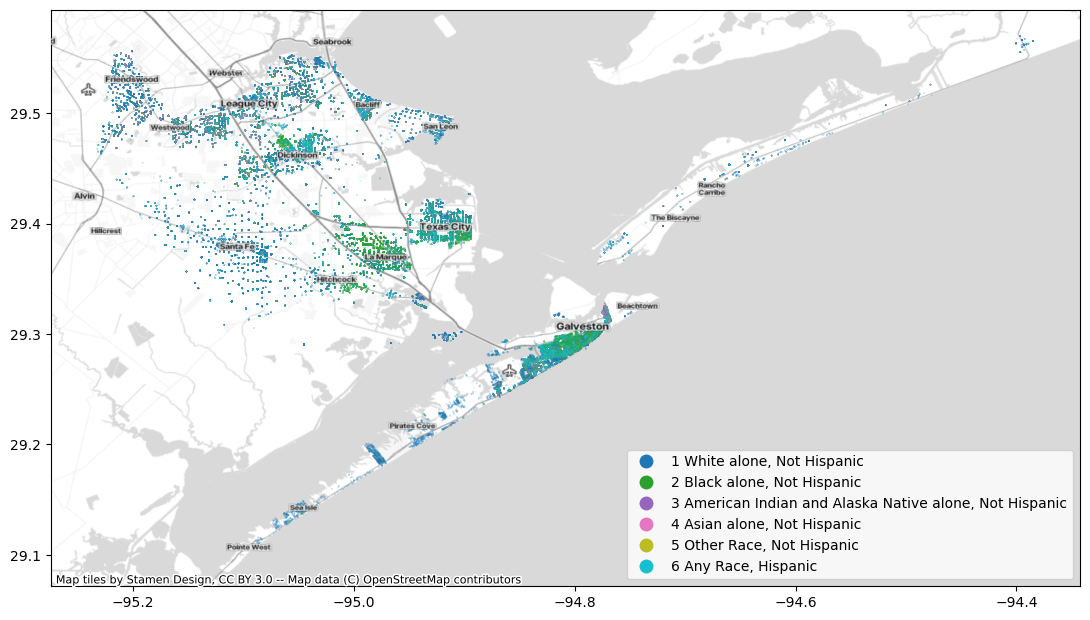

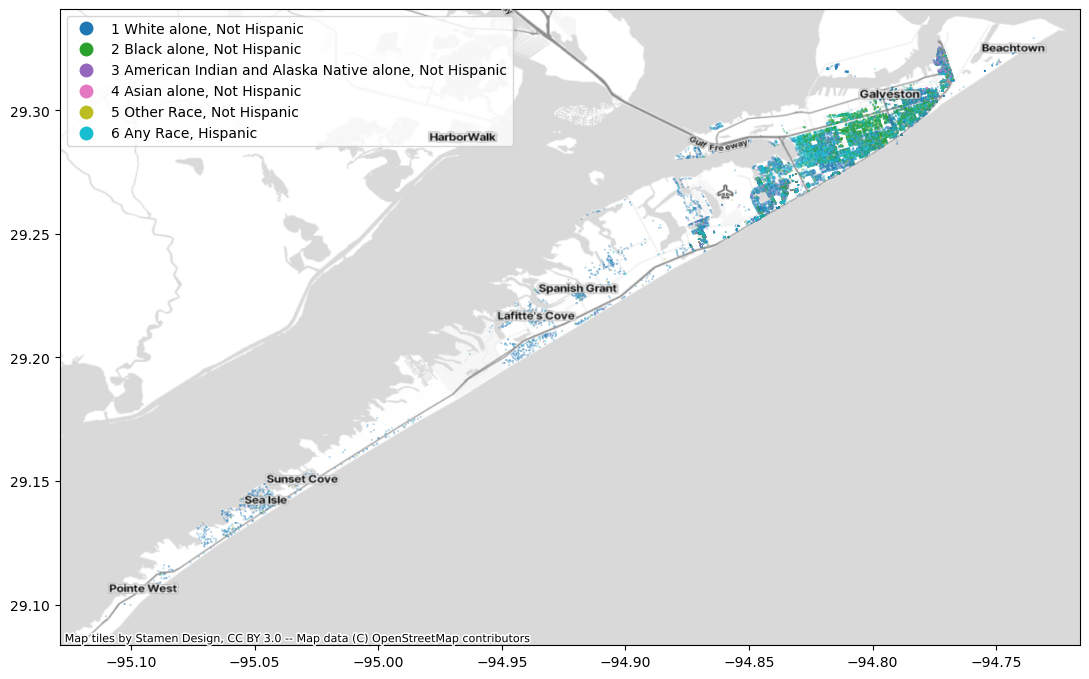

In [33]:
import contextily as cx # For adding basemap tiles to plot
import matplotlib.pyplot as plt # For plotting and making graphs

#mapname = 'hhincdotmap'
mapname = 'hhracedotmap'
# Map column
#map_var = 'Household Income Group'
map_var = 'Race Ethnicity'
condition1 = "(hua_hui_race_gdf.race >= 1)"
#condition3 = "(hua_hui_race_gdf['Building Data Availability_int'] == 1)"
place = focalplace
condition2 = f"(hua_hui_race_gdf.placeNAME10 == '{place}')"

condition_list = {1 : f"{condition1}",
                  2 : f"{condition1} & {condition2}"
                } 

for item in condition_list.keys():
    condition =  condition_list[item]
    # Obtain data
    popdata = hua_hui_race_gdf.loc[eval(condition)].copy(deep=True)
    hua_data = popdata.to_crs(epsg=4326)

    # Get min and max x and y values
    # Find the bounds of the gdf File
    minx = hua_data.bounds.minx.min()
    miny = hua_data.bounds.miny.min()
    maxx = hua_data.bounds.maxx.max()
    maxy = hua_data.bounds.maxy.max()
    x_range = maxx - minx
    #print(x_range)
    # make maker size inverse to the range of x values
    marker_size = .01/x_range
    #print(marker_size)

    # Set save file
    #  save hua_hui_gdf to csv
    check_folder = f"{outputfolder}/{community}/06_Explore"
    output_filename = f'{mapname}_{community}_{item}_{bldg_inv_id}'
    filepath = check_folder+"/"+output_filename

    ''' Need to sort out figure and axes
    # Set figure size (width, height) in inches
    #plt.figure(figsize = ( 14 , 12 ))
    plt.rcParams["figure.figsize"] = [11.00, 8.5]
    plt.rcParams["figure.autolayout"] = True

    # Figure Title
    by_label = "Race Ethnicity"
    who = f"Housing Unit Locations"
    what = f"by {by_label}"
    where = "Lumberton, NC"
    when = "2010"
    table_title = who +" "+ what+", \n "+ where +", "+ when +"."


    # Set title for figure
    plt.title( table_title, size = 18)

    notes = "notes here"
    plt.gcf().text(0, 0, notes, 
                            va = 'bottom', ha='left',
                            fontstyle='italic', size=6)
    '''

    plt.rcParams["figure.figsize"] = [11.00, 8.5]
    plt.rcParams["figure.autolayout"] = True

    
    # Plot the data
    ax = hua_data.plot(column=map_var,
                        categorical=True, 
                        legend=True, 
                        markersize = marker_size)
    cx.add_basemap(ax, crs = hua_data.crs, 
            source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax, crs = hua_data.crs, 
            source=cx.providers.Stamen.TonerLabels)

    ax.figure.savefig(filepath+'v2.svg', 
                bbox_inches="tight",format = 'svg', 
                dpi=600)

    ax.figure.savefig(filepath+'v2.png', 
                bbox_inches="tight",format = 'png', 
                dpi=600)


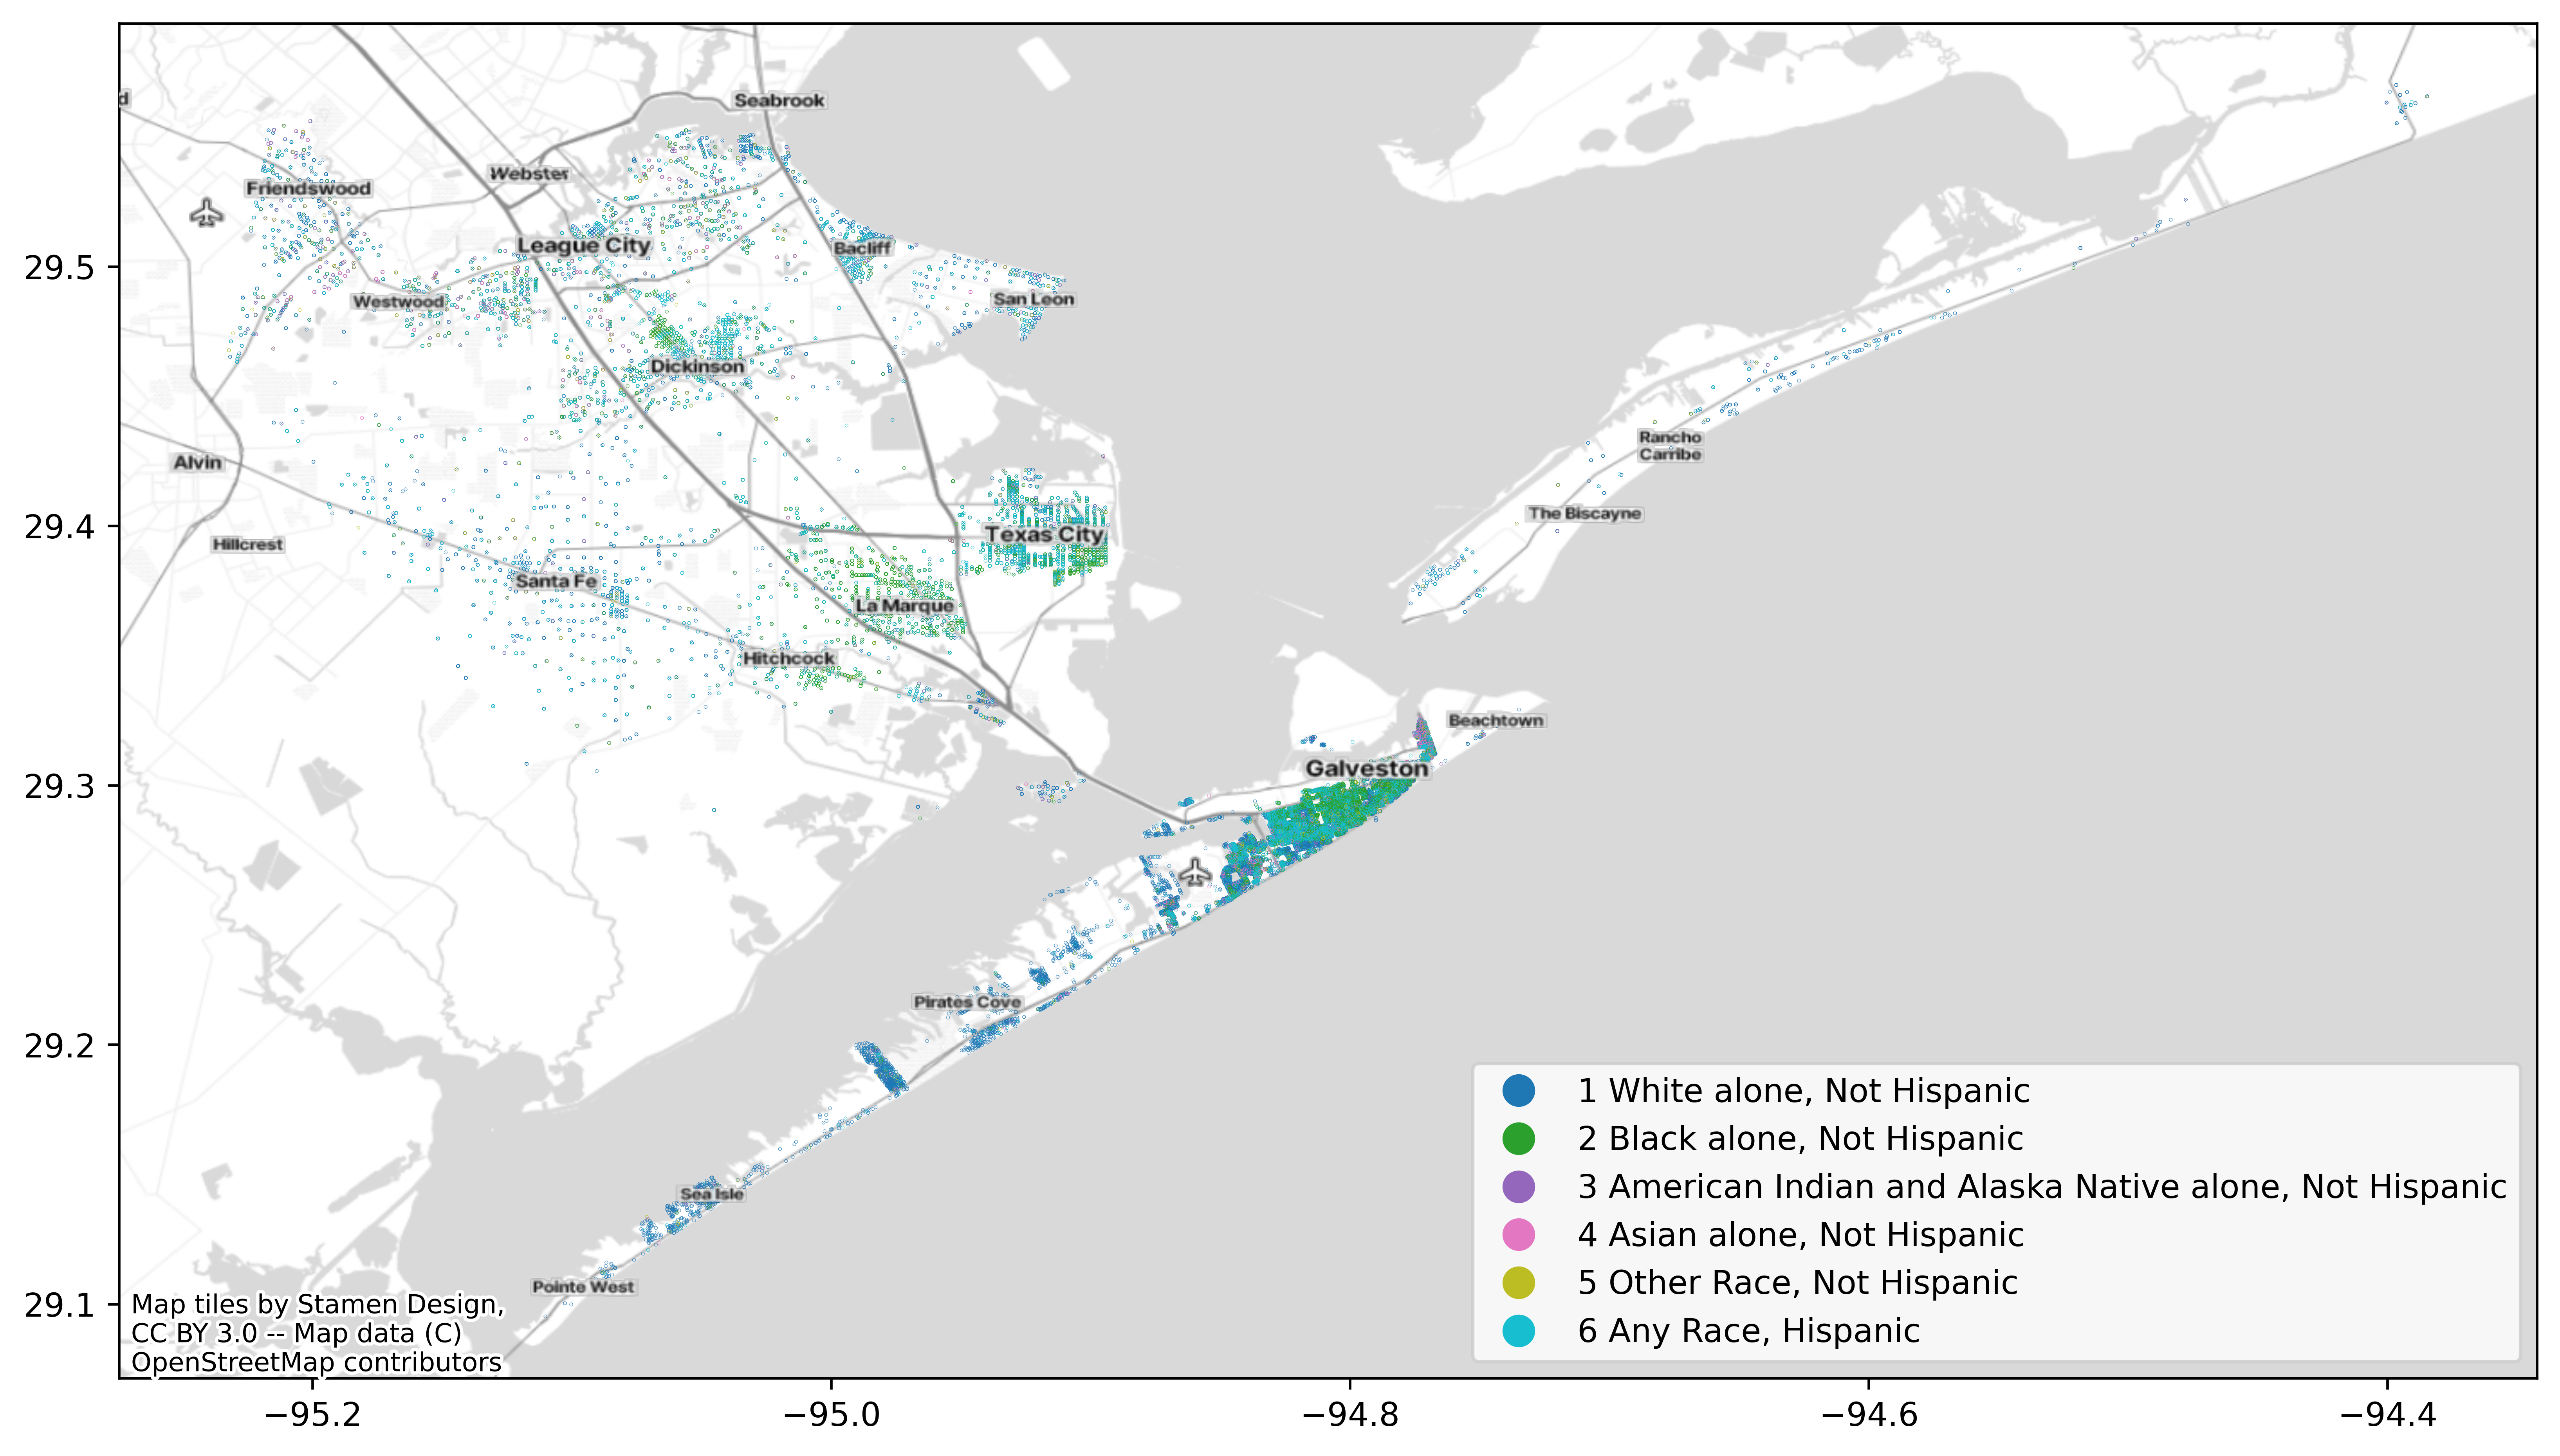

In [34]:
# plot png file
from IPython.display import Image
check_folder = f"{outputfolder}/{community}/06_Explore"
output_filename = f'{mapname}_{community}_{1}_{bldg_inv_id}'
filepath = check_folder+"/"+output_filename
Image(filename = filepath+'v2.png', width= 800, height=800)

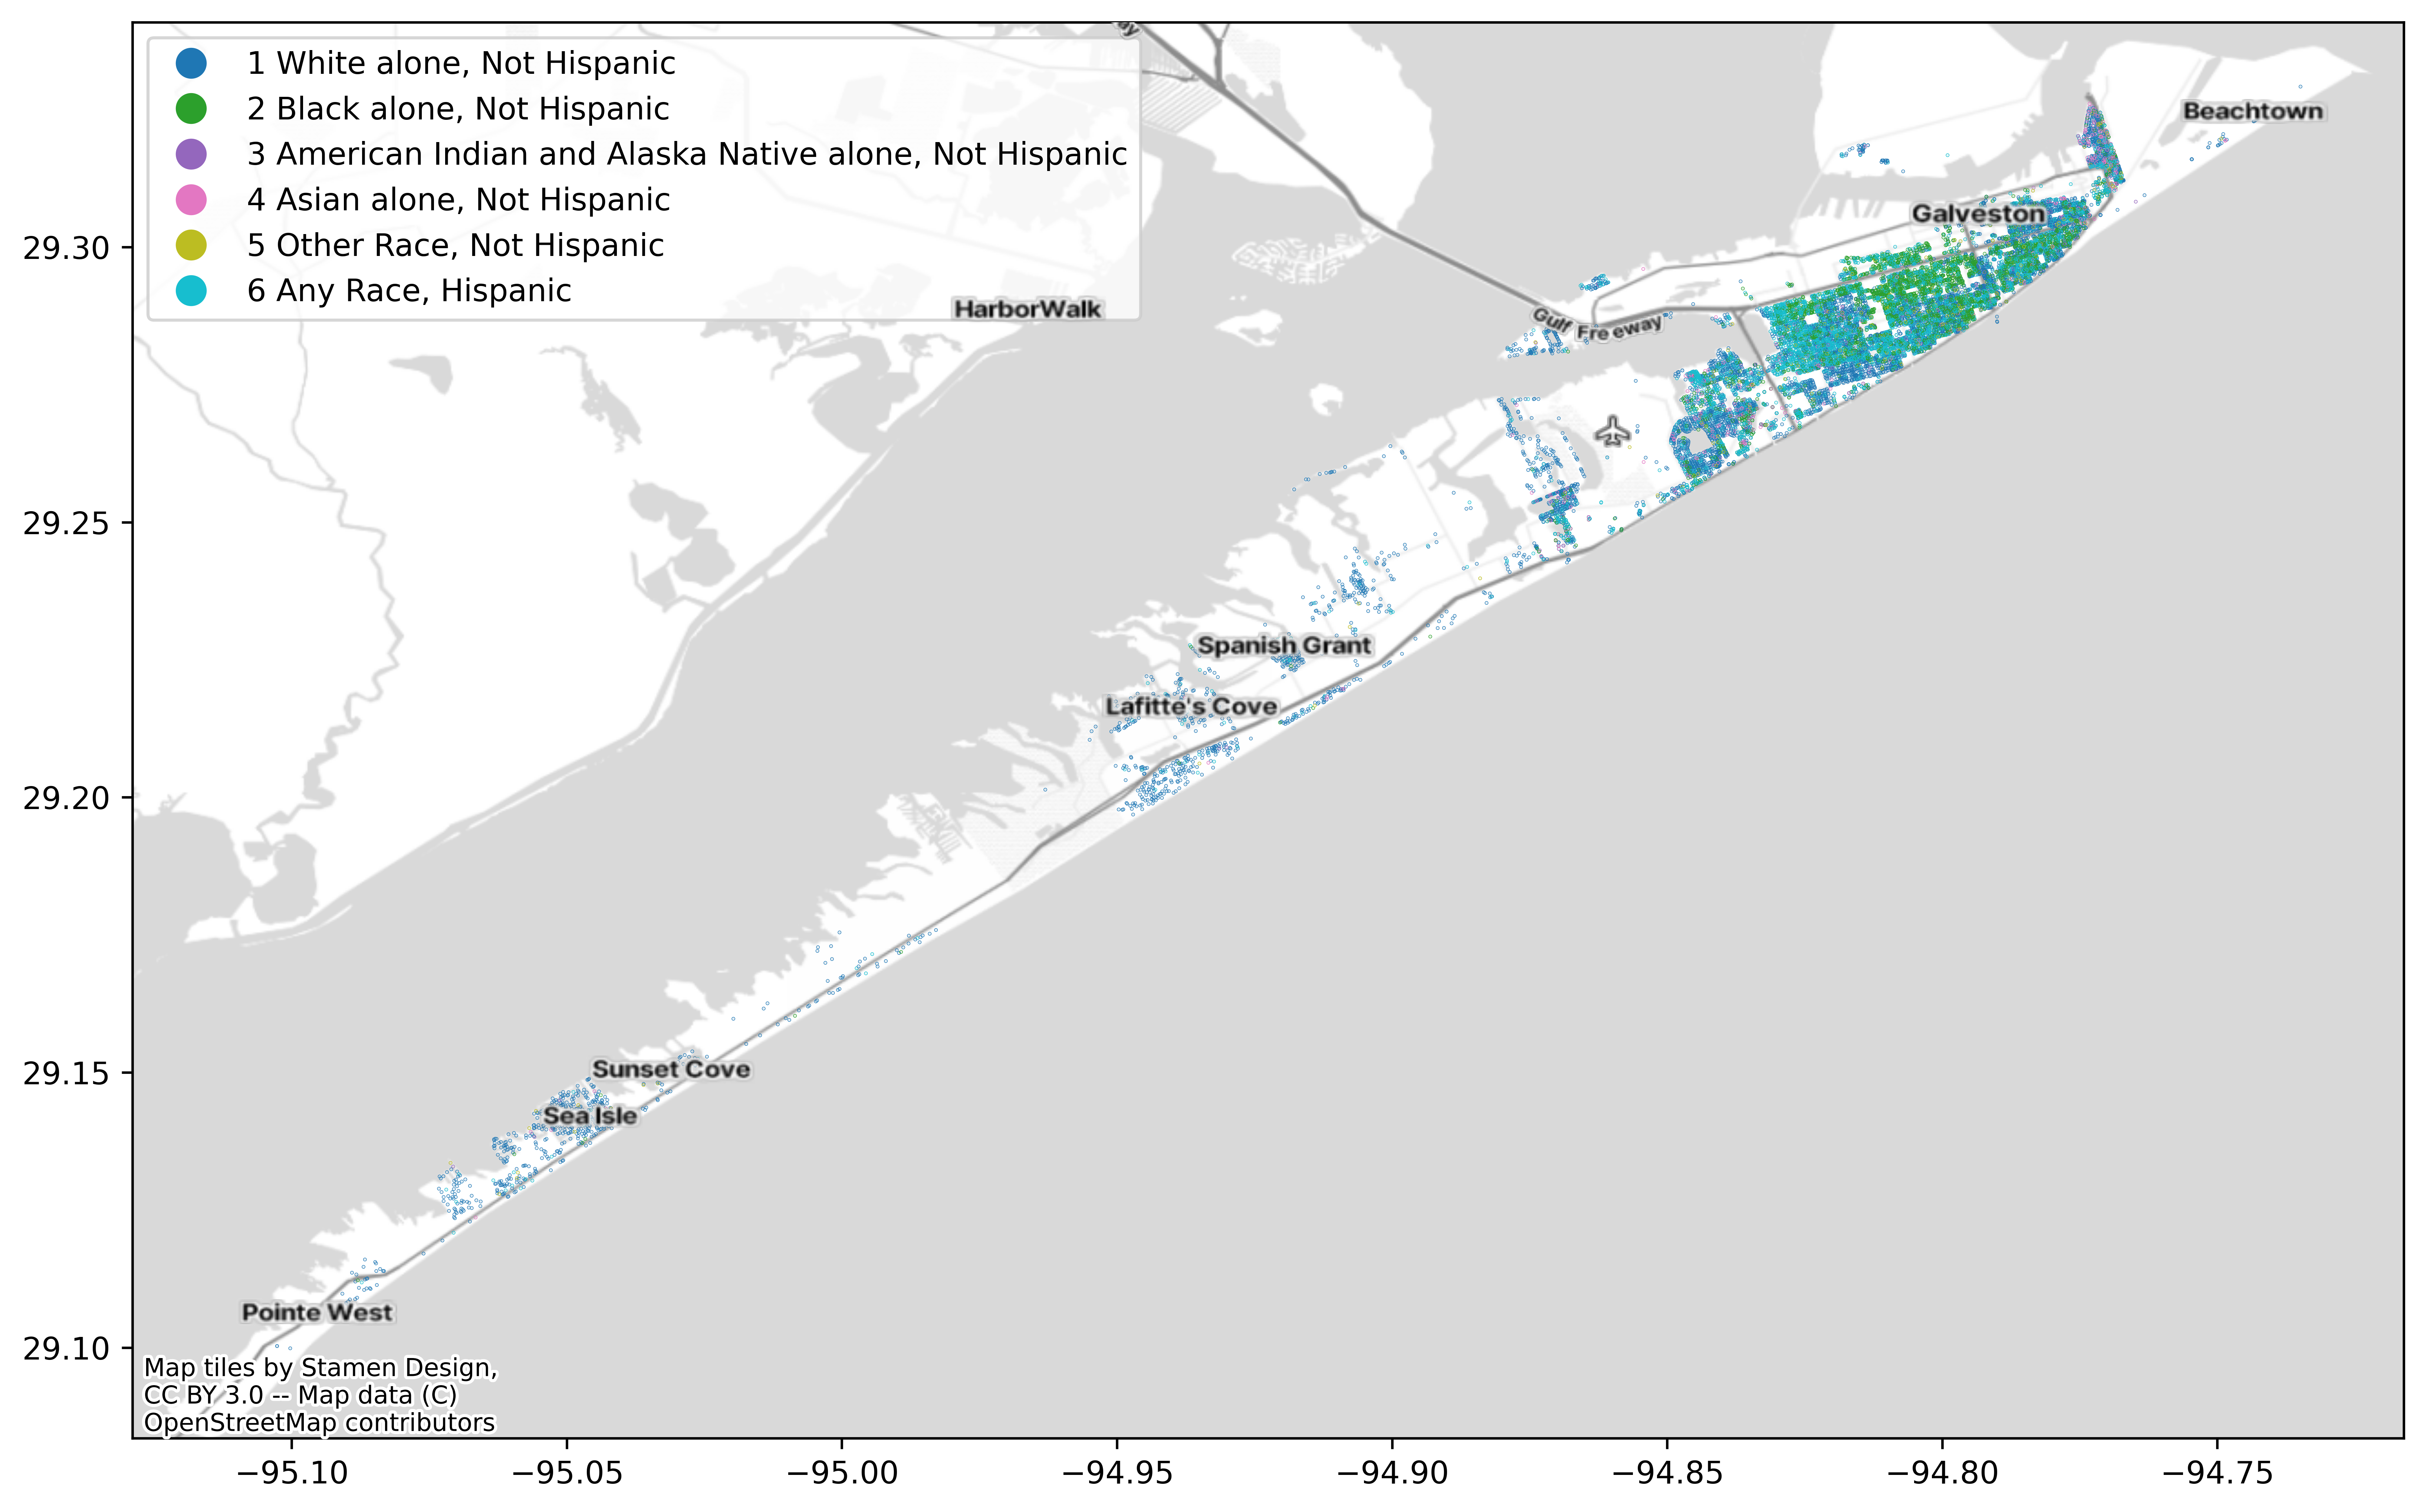

In [35]:
# plot png file
from IPython.display import Image
check_folder = f"{outputfolder}/{community}/06_Explore"
output_filename = f'{mapname}_{community}_{2}_{bldg_inv_id}'
filepath = check_folder+"/"+output_filename
Image(filename = filepath+'v2.png', width= 800, height=800)

In [36]:
communities = {'Lumberton_NC' : {
                    'community_name' : 'Lumberton, NC',
                    'focalplace_name' : 'Lumberton',
                    'STATE' : 'NORTH_CAROLINA',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '37155', 'Name' : 'Robeson County, NC'}},
                    'building_inventory' : { 
                        'id' : '62ab7dcbf328861e25ffea9e',
                        'note' : 'Building inventory for Robeson County, NC',
                        'archetype_var' : 'archetype',
                        'residential_archetypes' : Nofal_residential_archetypesv2,
                        'building_area_var' : 'sq_foot'}
                                }
                }
communities = {'Galveston_TX' : {
                    'community_name' : 'Galveston, TX',
                    'focalplace_name' : 'Galveston',
                    'STATE' : 'TEXAS',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '48167', 'Name' : 'Galveston County, TX'}},
                    'building_inventory' : { 
                        'id' : '63053ddaf5438e1f8c517fed',
                        'note' : 'Building inventory for Galveston County, TX',
                        'archetype_var' : 'arch_flood',
                        'residential_archetypes' : Nofal_residential_archetypesv2,
                        'building_area_var' : 'sq_foot'}
                                }
                }

communities = {'Mayfield_KY' : {
                    'community_name' : 'Mayfield, KY',
                    'focalplace_name' : 'Mayfield',
                    'STATE' : 'KENTUCKY',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '21083', 'Name' : 'Graves County, KY'}},
                    'building_inventory' : { 
                        'id' : 'NSI',
                        'note' : 'NSI Building inventory for Graves County, KY',
                        'archetype_var' : 'occtype',
                        'bldg_uniqueid' : 'fd_id_bid',
                        'residential_archetypes' : HAZUS_residential_archetypes,
                        'building_area_var' : 'sqft',
                        'building_area_cutoff' : 300}
                                }
                }


communities = {'Beaumont_TX' : {
                    'community_name' : 'Beaumont, TX',
                    'focalplace_name' : 'Beaumont',
                    'STATE' : 'TEXAS',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '48245', 'Name' : 'Jefferson, TX'}},
                    'building_inventory' : { 
                        'id' : 'NSI',
                        'note' : 'NSI Building inventory for Jefferson County, TX',
                        'archetype_var' : 'occtype',
                        'bldg_uniqueid' : 'fd_id_bid',
                        'residential_archetypes' : HAZUS_residential_archetypes,
                        'building_area_var' : 'sqft',
                        'building_area_cutoff' : 300}
                                }
                }

communities = {'Oceana_MI' : {
                    'community_name' : 'Pentwater, MI',
                    'focalplace_name' : 'Pentwater',
                    'STATE' : 'MICHIGAN',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '26127', 'Name' : 'Oceana County, MI'}},
                    'building_inventory' : { 
                        'id' : 'NSI',
                        'note' : 'NSI Building inventory for Oceana County, MI',
                        'archetype_var' : 'occtype',
                        'bldg_uniqueid' : 'fd_id_bid',
                        'residential_archetypes' : HAZUS_residential_archetypes,
                        'building_area_var' : 'sqft',
                        'building_area_cutoff' : 300}
                                }
                }